In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [72]:
# input_location = 'KTH-split/alloc-only'
input_location = 'KTH-split/io-aware'
num_parts = 16
# schedule_names = ['filler', 'backfill-1', 'no-future-1', 'fcfs']
schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'window-10-1', 'plan-opt-square-0', 'plan-opt-cube-0']
new_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0']

In [73]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]

In [74]:
jobsets = {schedule: [None] * num_parts for schedule in schedule_names}
for file in jobs_files:
    schedule_name, part, _ = os.path.basename(file).split('_')
    part_index = int(part.split('-')[1])
    if schedule_name in schedule_names:
        jobsets[schedule_name][part_index] = JobSet.from_csv(file)

In [75]:
def transform_jobset_df(df):
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [76]:
for schedule in schedule_names:
    for i in range(len(jobsets[schedule])):
        jobsets[schedule][i].df = transform_jobset_df(jobsets[schedule][i].df)

In [77]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_data_df():
    dfs = []
    for schedule in schedule_names:
        for i in range(len(jobsets[schedule])):
            df = jobsets[schedule][i].df
            df = df.assign(schedule=schedule, part=i, bounded_slowdown=bounded_slowdown(df))[['schedule', 'part', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
            df.rename({'stretch': 'slowdown'}, axis=1, inplace=True)
            dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [78]:
# rename schedules
new_jobsets = {}
for old_name, new_name in zip(schedule_names, new_names):
    new_jobsets[new_name] = jobsets[old_name]
schedule_names = new_names
jobsets = new_jobsets

In [79]:
all_data = create_all_data_df()

In [80]:
all_data['part'] += 1

In [10]:
# sns.set_theme(context='talk', style='white')
# deep_palette = sns.color_palette("deep")

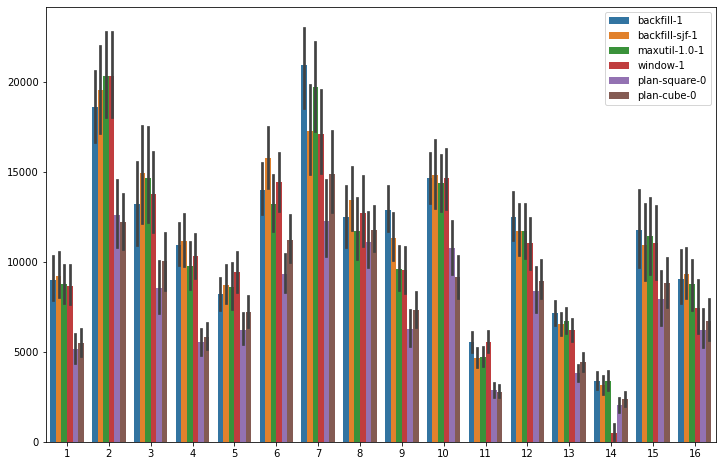

In [82]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=all_data, x='part', y='waiting_time', hue='schedule', ax=ax)
# sns.barplot(data=all_data, x='part', y='waiting_time', hue='schedule', hue_order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], ax=ax)
# ax.set_yscale('log')
# ax.set_ylim(top=10**6)
# ax.grid(axis='y')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend(title=None)
plt.legend(loc='upper right')
fig.savefig('../../images/results/best_io-aware_parts_waiting-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_waiting-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_io-aware_parts_waiting-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_alloc-only_parts_waiting-time.pdf', bbox_inches='tight')

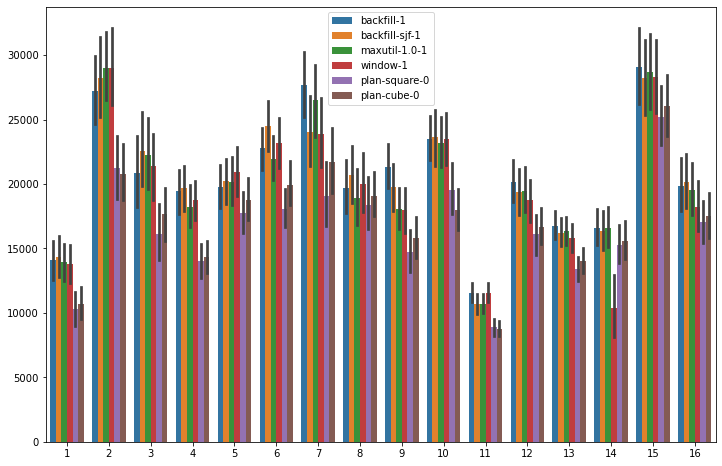

In [83]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=all_data, x='part', y='turnaround_time', hue='schedule', ax=ax)
# sns.barplot(data=all_data, x='part', y='turnaround_time', hue='schedule', hue_order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], ax=ax)
# ax.set_yscale('log')
# ax.set_ylim(top=60000)
# ax.set_ylim(top=10**6)
# ax.grid(axis='y')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend(title=None)
# plt.legend(loc='upper left')
fig.savefig('../../images/results/best_io-aware_parts_turnaround-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_turnaround-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_io-aware_parts_turnaround-time.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_alloc-only_parts_turnaround-time.pdf', bbox_inches='tight')

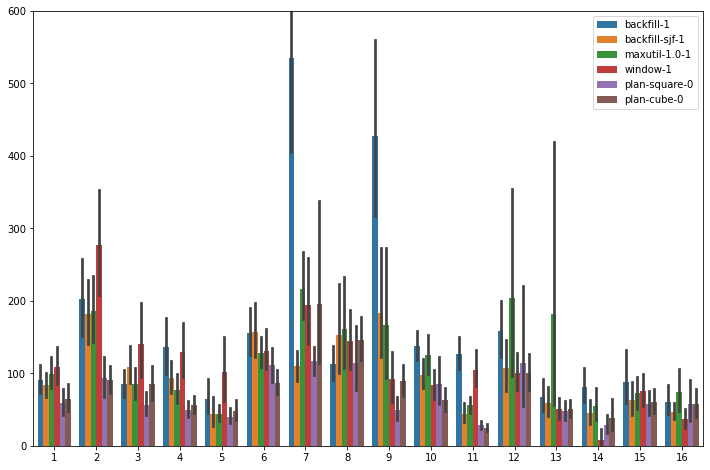

In [85]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=all_data, x='part', y='slowdown', hue='schedule', ax=ax)
# sns.barplot(data=all_data, x='part', y='slowdown', hue='schedule', hue_order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], ax=ax)
# ax.set_yscale('log')
ax.set_ylim(top=600)
# ax.set_ylim(top=10**5)
# ax.grid(axis='y')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend(title=None)
# plt.legend(loc='upper right')
fig.savefig('../../images/results/best_io-aware_parts_slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_io-aware_parts_slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_alloc-only_parts_slowdown.pdf', bbox_inches='tight')

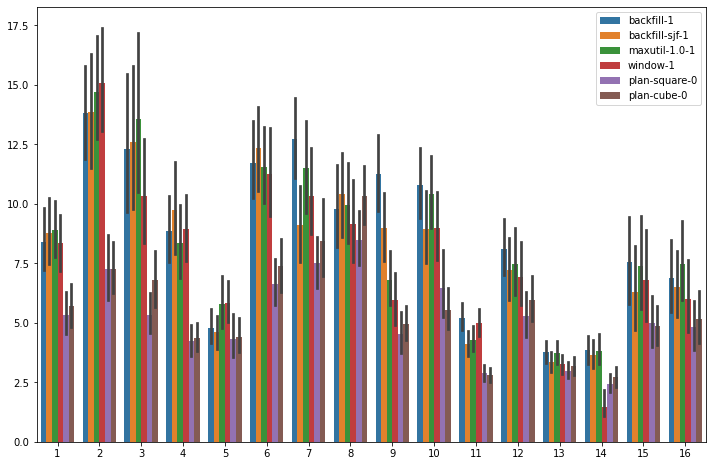

In [86]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=all_data, x='part', y='bounded_slowdown', hue='schedule', ax=ax)
# sns.barplot(data=all_data, x='part', y='bounded_slowdown', hue='schedule', hue_order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], ax=ax)
# ax.set_yscale('log')
# ax.set_ylim(top=10**3)
# ax.grid(axis='y')
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend(title=None)
plt.legend(loc='upper right')
fig.savefig('../../images/results/best_io-aware_parts_bounded-slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_bounded-slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_io-aware_parts_bounded-slowdown.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/reservation_alloc-only_parts_bounded-slowdown.pdf', bbox_inches='tight')

In [15]:
sns.set_theme(context='talk', style='whitegrid')

In [16]:
aggregated = all_data.groupby(['schedule', 'part']).mean()
mean_data = aggregated.reset_index(level=[0,1])

<AxesSubplot:xlabel='schedule', ylabel='waiting_time'>

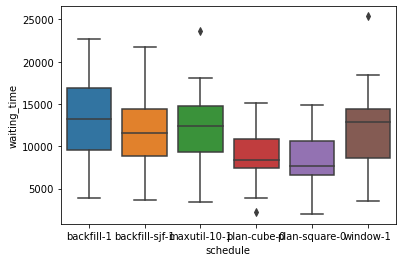

In [20]:
sns.boxplot(data=mean_data, x='schedule', y='waiting_time')

In [17]:
normalised = aggregated.copy()
for schedule in schedule_names:
    for i in range(num_parts):
        normalised.loc[schedule, i] = aggregated.loc[schedule, i] / aggregated.loc['backfill-sjf-1', i]
mean_normalised = normalised.reset_index(level=[0,1])

<AxesSubplot:xlabel='schedule', ylabel='waiting_time'>

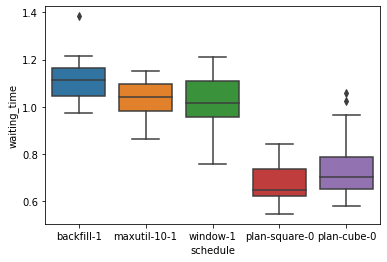

In [29]:
sns.boxplot(data=mean_normalised, x='schedule', y='waiting_time', order=['backfill-1', 'maxutil-10-1', 'window-1', 'plan-square-0', 'plan-cube-0'])

In [18]:
palette = sns.color_palette("deep")
palette.pop(1)
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

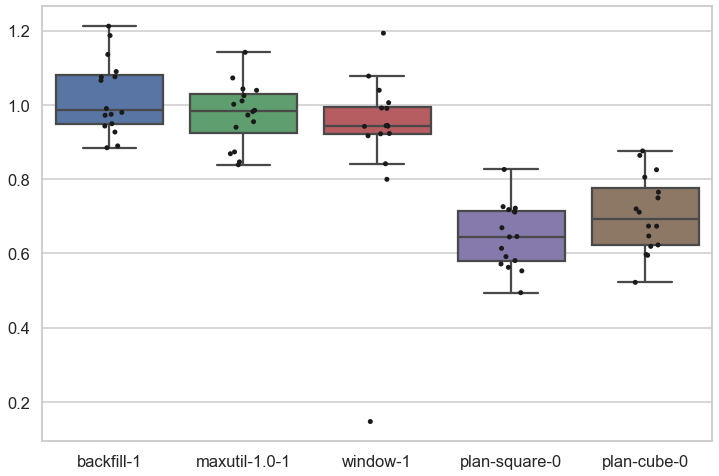

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=mean_normalised, x='schedule', y='waiting_time', fliersize=False, order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'], palette=palette)
sns.stripplot(data=mean_normalised, x='schedule', y='waiting_time', color=".1", order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'])
# sns.swarmplot(data=mean_normalised, x='schedule', y='waiting_time', color=".1", order=['backfill-1', 'maxutil-10-1', 'window-1', 'plan-square-0', 'plan-cube-0'])
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_io-aware_parts_waiting-time_box.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_waiting-time_box.pdf', bbox_inches='tight')

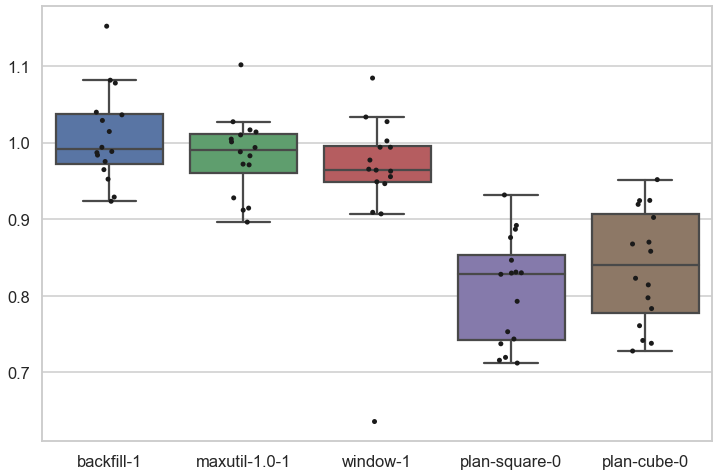

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=mean_normalised, x='schedule', y='turnaround_time', fliersize=False, order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'], palette=palette)
sns.stripplot(data=mean_normalised, x='schedule', y='turnaround_time', color=".1", order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'])
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_io-aware_parts_turnaround-time_box.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_turnaround-time_box.pdf', bbox_inches='tight')

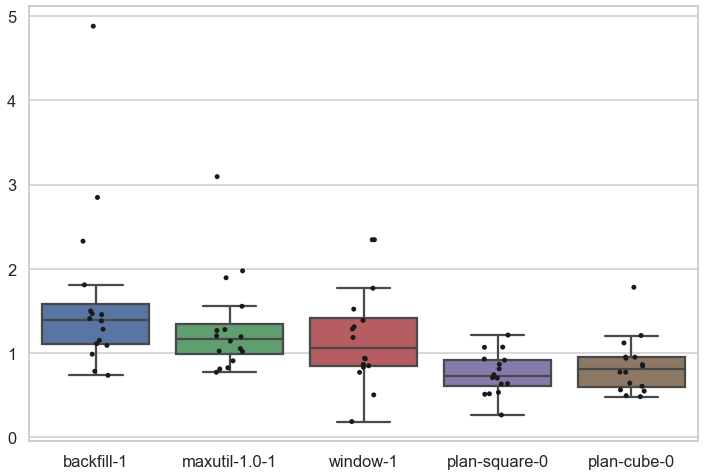

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=mean_normalised, x='schedule', y='slowdown', fliersize=False, order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'], palette=palette)
sns.stripplot(data=mean_normalised, x='schedule', y='slowdown', color=".1", order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'])
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_io-aware_parts_slowdown_box.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_slowdown_box.pdf', bbox_inches='tight')

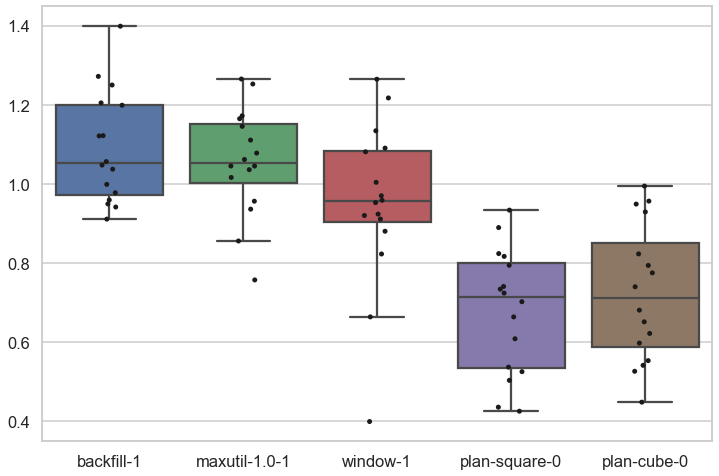

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=mean_normalised, x='schedule', y='bounded_slowdown', fliersize=False, order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'], palette=palette)
sns.stripplot(data=mean_normalised, x='schedule', y='bounded_slowdown', color=".1", order=['backfill-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0'])
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_io-aware_parts_bounded-slowdown_box.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_alloc-only_parts_bounded-slowdown_box.pdf', bbox_inches='tight')